# **Capítulo 3: Fontes de Dados Financeiros com Python**

Neste capítulo, vamos aprender a usar bibliotecas Python especializadas para buscar dados financeiros diretamente de fontes online, como cotações de ações, moedas e indicadores econômicos. Isso elimina a necessidade de baixar arquivos manualmente.

## **3.1 Bibliotecas para Dados Financeiros**

Existem diversas bibliotecas em Python para se conectar a fontes de dados (APIs). As duas que usaremos como principais exemplos são:

1.  **`yfinance`**: Uma biblioteca extremamente popular para baixar dados de cotações de ações, ETFs e índices do Yahoo Finance.
2.  **`python-bcb`**: Para obter séries temporais de dados econômicos brasileiros diretamente do Sistema Gerenciador de Séries Temporais (SGS) do Banco Central do Brasil.

### **3.1.1 yfinance: Cotações de Ações e Índices**

O `yfinance` é a ferramenta ideal para obter dados de ativos negociados em bolsa. Para ações brasileiras, usamos o mesmo código do home broker, adicionando o sufixo `.SA` (ex: `PETR4.SA`). A principal função que usaremos é a `yf.download()`.

Primeiro, você precisa instalar a biblioteca no seu terminal.

**No seu terminal (apenas uma vez):**
```bash

In [ ]:
pip install yfinance

Um passo fundamental após carregar um conjunto de dados é inspecioná-lo para garantir que tudo está correto. Vamos dar uma olhada nas primeiras e últimas linhas do nosso DataFrame da PETR4.

Para isso, usamos dois métodos muito úteis do Pandas:
* `.head()`: Exibe as 5 primeiras linhas.
* `.tail()`: Exibe as 5 últimas linhas.

In [ ]:
import yfinance as yf

# Baixando dados diários da Petrobras (PETR4) para o ano de 2023
# A função retorna um DataFrame do Pandas
petr4 = yf.download('PETR4.SA', start='2023-01-01', end='2023-12-31', auto_adjust=False)

# Exibindo as 5 primeiras linhas
print("--- Dados da PETR4 ---")
print(petr4.head())

# Exibindo as 5 últimas linhas
print("\n--- Fim dos Dados da PETR4 ---")
print(petr4.tail())

A função retorna um DataFrame com as seguintes colunas: `Open` (abertura), `High` (máxima), `Low` (mínima), `Close` (fechamento), `Adj Close` (fechamento ajustado para proventos) e `Volume`.

Também podemos baixar dados de múltiplos ativos de uma só vez.

In [ ]:
import yfinance as yf

# Definindo os tickers e o período
tickers = ['ITSA4.SA', 'VALE3.SA', '^BVSP']
start_date = '2023-01-01'
end_date = '2023-12-31'

# 1. Baixamos o DataFrame completo, com todos os dados (Open, High, Low, Close, etc.)
dados_completos = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# 2. (Opcional) Vamos inspecionar a estrutura das colunas para entender
print("--- Estrutura das Colunas (MultiIndex) ---")
print(dados_completos.columns)

# 3. Agora, selecionamos o nível superior 'Adj Close'. Isso nos dará um DataFrame
#    apenas com os preços de fechamento ajustado de todos os tickers.
dados_adj_close = dados_completos['Adj Close']
dados_close = dados_completos['Close']

# 4. Exibindo as 5 primeiras linhas do resultado correto
print("\n--- DataFrame Apenas com 'Adj Close' ---")
print(dados_adj_close.head())
print("\n--- DataFrame Apenas com 'Close' ---")
print(dados_close.head())

## **3.1.2 python-bcb: Dados Econômicos do Banco Central do Brasil**

Para obter dados da economia brasileira, como a taxa Selic, IPCA, IGP-M ou a cotação do dólar, usamos a biblioteca `python-bcb`. Ela se conecta diretamente ao **SGS (Sistema Gerenciador de Séries Temporais)** do Banco Central do Brasil.

Primeiro, você precisa instalar a biblioteca no seu terminal.

**No seu terminal (apenas uma vez):**
```bash

In [ ]:
pip install python-bcb

Cada série de dados no Banco Central tem um código único. Para encontrar o código de uma série, podemos usar a função `sgs.search_sgs()`. Depois, usamos o código encontrado na função `sgs.get()` para baixar os dados.

In [ ]:
from bcb import sgs

# Vamos usar o código 11, que sabemos ser da taxa Selic diária.
# Passamos um dicionário onde a chave é o nome que queremos para a coluna ('Selic') 
# e o valor é o código (11).
selic = sgs.get({'Selic': 11}, start='2023-01-01')

print("--- Histórico da Taxa Selic Diária ---")
print(selic.tail()) # Usando .tail() para ver os dados mais recentes

In [ ]:
# Baixando os últimos 12 meses do IPCA (código 433) e do IGP-M (código 189)
inflacao = sgs.get({'IPCA': 433, 'IGP-M': 189}, last=12)

print("\n--- Últimos 12 meses de Inflação (IPCA vs IGP-M) ---")
print(inflacao.head())

A busca nos mostra que a taxa Selic diária tem o código **11**. Agora, vamos usar esse código para baixar os dados históricos.

In [ ]:
# Baixando a série da Selic a partir de 01/01/2023
# Passamos um dicionário onde a chave é o nome que queremos para a coluna e o valor é o código
selic = sgs.get({'Selic': 11}, start='2023-01-01')

print("--- Histórico da Taxa Selic Diária ---")
print(selic.head())

Também podemos baixar múltiplas séries de uma vez, passando um dicionário com vários códigos.

In [ ]:
# Baixando os últimos 12 meses do IPCA (código 433) e do IGP-M (código 189)
inflacao = sgs.get({'IPCA': 433, 'IGP-M': 189}, last=12)

print("--- Últimos 12 meses de Inflação (IPCA vs IGP-M) ---")
print(inflacao.head())

## **3.2 Manipulação de Séries Temporais com Pandas**

Tanto o `yfinance` quanto o `python-bcb` retornam DataFrames do Pandas, que são perfeitos para análise de séries temporais. A principal característica que torna isso possível é o **`DatetimeIndex`**, um tipo especial de índice composto por datas. Ter as datas como índice nos permite agrupar, fatiar e manipular os dados com base no tempo de forma muito eficiente.

In [ ]:
import yfinance as yf

# Vamos baixar um ativo de exemplo para esta seção
itsa4 = yf.download('ITSA4.SA', start='2022-01-01', end='2023-12-31')

# Vamos verificar o tipo do índice do nosso DataFrame
print(f"O tipo do índice é: {type(itsa4.index)}")

print("\nVisualizando os dados:")
print(itsa4.head())

Um DataFrame com `DatetimeIndex` tem dois componentes principais que podemos acessar separadamente:
* **`.index`**: O objeto que contém todas as datas (o índice).
* **`.values`**: Um array NumPy contendo todos os valores numéricos do DataFrame (os dados em si).

In [ ]:
# Acessando apenas o índice (as datas)
print("--- Objeto de Índice (Datas) ---")
print(itsa4.index)


# Acessando apenas os valores (como uma matriz)
print("\n--- Array de Valores ---")
print(itsa4.values)

### Convertendo a Periodicidade (Resample)

Uma das tarefas mais comuns é mudar a frequência dos dados (ex: de diário para mensal). No Pandas, fazemos isso com o método `.resample()`. Ele agrupa os dados por uma nova frequência e depois aplicamos uma função de agregação (como `.last()`, `.first()`, `.sum()`, `.mean()`) para definir como os dados agrupados devem ser representados.

Usamos códigos para definir a frequência:
* `M`: Fim do Mês (`Month End`)
* `MS`: Início do Mês (`Month Start`)
* `Q`: Fim do Trimestre (`Quarter End`)
* `Y`: Fim do Ano (`Year End`)

In [ ]:
# Resample para dados mensais, pegando o último preço de cada mês
itsa4_mensal = itsa4.resample('ME').last()
print("--- Dados Mensais (Último dia do Mês) ---")
print(itsa4_mensal.head())

# Resample para dados trimestrais, calculando o preço médio de cada trimestre
itsa4_trimestral = itsa4.resample('QE').mean()
print("\n--- Dados Trimestrais (Média do Trimestre) ---")
print(itsa4_trimestral.head())

### Movendo o Índice de Data para uma Coluna

Às vezes, é útil ter a data como uma coluna normal do DataFrame em vez de ser o índice. Para fazer isso, usamos o método `.reset_index()`.

In [ ]:
# Criando uma cópia para não alterar nosso DataFrame original
itsa4_com_coluna_data = itsa4.reset_index()

print("--- DataFrame com a data como coluna ---")
print(itsa4_com_coluna_data.head())

## **3.3 Selecionando Colunas Específicas (Open, High, Low, Close)**

Diferente de algumas bibliotecas do R, o Pandas não precisa de funções "ajudantes" (helpers) para selecionar colunas específicas como `Open`, `High`, `Low` ou `Close`.

A seleção é feita de forma direta e intuitiva, simplesmente passando o nome da coluna desejada entre colchetes `[]` no DataFrame. O resultado será uma `Series` do Pandas contendo apenas os dados daquela coluna.

In [ ]:
# Usando o DataFrame 'itsa4' que já baixamos e o dados_adj_close que fizemos no 3.1.1

# Selecionar apenas a coluna de Fechamento ('Close')
precos_fechamento = itsa4['Close']
print("--- Apenas Preços de Fechamento ---")
print(precos_fechamento.head())


# Selecionar apenas a coluna de Abertura ('Open')
precos_abertura = itsa4['Open']
print("\n--- Apenas Preços de Abertura ---")
print(precos_abertura.head())


# Selecionar apenas a coluna de Preço Máximo ('High')
precos_maximos = itsa4['High']
print("\n--- Apenas Preços Máximos ---")
print(precos_maximos.head())


# Selecionar a coluna de Fechamento Ajustado ('Adj Close') usando o DataFrame correto
precos_ajustados = dados_adj_close['ITSA4.SA']
print("\n--- Apenas Preços de Fechamento Ajustado (ITSA4.SA) ---")
print(precos_ajustados.head())

--- Apenas Preços de Fechamento ---
Ticker      ITSA4.SA
Date                
2022-01-03  5.547342
2022-01-04  5.590392
2022-01-05  5.528892
2022-01-06  5.578093
2022-01-07  5.645743

--- Apenas Preços de Abertura ---
Ticker      ITSA4.SA
Date                
2022-01-03  5.547342
2022-01-04  5.553491
2022-01-05  5.565793
2022-01-06  5.522743
2022-01-07  5.578092

--- Apenas Preços Máximos ---
Ticker      ITSA4.SA
Date                
2022-01-03  5.651893
2022-01-04  5.639592
2022-01-05  5.602693
2022-01-06  5.621143
2022-01-07  5.651893

--- Apenas Preços de Fechamento Ajustado (ITSA4.SA) ---
Date
2023-01-02    6.042832
2023-01-03    5.891037
2023-01-04    5.941634
2023-01-05    6.028375
2023-01-06    6.129570
Name: ITSA4.SA, dtype: float64


## **3.4 Gráficos Financeiros com mplfinance**

Embora possamos fazer gráficos de linha com Seaborn, para visualizações financeiras mais completas (como gráficos de candlestick com volume), usamos uma biblioteca especializada chamada `mplfinance`. Ela é o equivalente direto da função `chartSeries` do R e foi criada para trabalhar perfeitamente com DataFrames do Pandas.

Primeiro, você precisa instalar a biblioteca no seu terminal.

**No seu terminal (apenas uma vez):**
```bash

In [ ]:
pip install mplfinance

C:\Users\Centauro\AppData\Local\Temp\ipykernel_15264\3986447819.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  itsa4 = yf.download('ITSA4.SA', start='2022-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


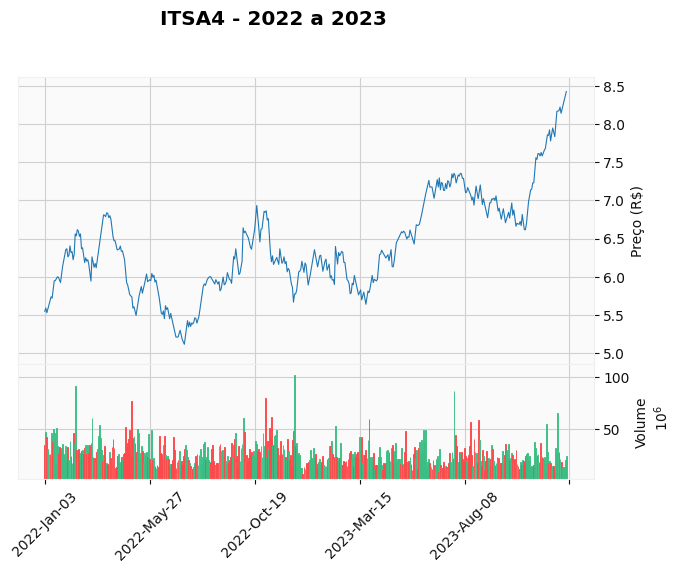

In [ ]:
import yfinance as yf
import mplfinance as mpf

# Vamos usar o DataFrame 'itsa4' que já temos
# Caso não o tenha, rode novamente:
# itsa4 = yf.download('ITSA4.SA', start='2022-01-01', end='2023-12-31')

# Ajustando os nomes das colunas para o formato esperado pelo mplfinance
itsa4_plot = itsa4.copy()
# ...código anterior...
# itsa4_plot = itsa4[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
# ...código posterior...
itsa4_plot.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# A função mpf.plot() é a principal da biblioteca.
# Por padrão, ela já cria um gráfico de linha para o preço e um painel separado para o volume.
mpf.plot(itsa4_plot, 
         type='line', 
         title='ITSA4 - 2022 a 2023', 
         ylabel='Preço (R$)',
         volume=True, 
         ylabel_lower='Volume',
         style='yahoo')

A grande vantagem do `mplfinance` é a facilidade para criar gráficos de candlestick. Basta mudar o argumento `type` para `'candle'`. Vamos visualizar apenas os últimos 60 dias de pregão para que os candles fiquem mais visíveis.

In [4]:
# Pegando os últimos 60 dias de dados do nosso DataFrame
itsa4_recente = itsa4.tail(60)

# Criando o gráfico de candlestick
mpf.plot(itsa4_recente, 
         type='candle', 
         title='ITSA4 - Últimos 60 Dias', 
         ylabel='Preço (R$)',
         volume=True, 
         ylabel_lower='Volume',
         style='yahoo')

ValueError: Data for column "Open" must be ALL float or int.